# **Step 1: Data Collection & Exploration**

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import joblib
from imblearn.over_sampling import SMOTE
import shap


In [2]:
# Load Data
from google.colab import files
uploaded = files.upload()

Saving customer_support_tickets.csv to customer_support_tickets.csv


**Data Exploration**

In [3]:
data = pd.read_csv('customer_support_tickets.csv')
data.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [5]:
# data.describe()
data.shape                            # Shape of the dataset 'date' - (8469, 17)

# Check for missing values
data.isnull().sum()

,0
Ticket ID,0
Customer Name,0
Customer Email,0
Customer Age,0
Customer Gender,0
Product Purchased,0
Date of Purchase,0
Ticket Type,0
Ticket Subject,0
Ticket Description,0


#**Step 2: Data Cleaning and Preprocessing**

In [6]:
# Filter 'Closed' tickets with non null Customer Satisfaction Rating values
data = data[data['Ticket Status'] == 'Closed'].dropna(subset=['Customer Satisfaction Rating'])            # Keeps only 'closed' tickets with ratings

# Confrim the shape of data after filtering
print('Shape of the data after fltering:',data.shape)

# Handle Missing Values (if any)
data['Resolution'].fillna('No Resolution', inplace=True)                                           # Replaces missing resoluion with 'No Resolution'
data['First Response Time'].fillna(data['First Response Time'].mode()[0], inplace=True)            # Replaces missing 'First Response Time' with mode value
data['Time to Resolution'].fillna(data['Time to Resolution'].mode()[0], inplace=True)              # Replaces missing 'Time to Resolution' with mode value

# Convert datetime columns
data['Date of Purchase'] = pd.to_datetime(data['Date of Purchase'])                                 # Converts the column from object type to datetime type
data['First Response Time'] = pd.to_datetime(data['First Response Time'])                           # Converts the column from object type to datetime type
data['Time to Resolution'] = pd.to_datetime(data['Time to Resolution'])                             # Converts the column from object type to datetime type


Shape of the data after fltering: (2769, 17)


In [7]:
# Confirm Check for missing values
data.isnull().sum()                                    # No null values found hooray!

,0
Ticket ID,0
Customer Name,0
Customer Email,0
Customer Age,0
Customer Gender,0
Product Purchased,0
Date of Purchase,0
Ticket Type,0
Ticket Subject,0
Ticket Description,0


**Text Preprocessing (NLP)**

In [8]:
# Basic Text preprocessing for 'Ticket Description'
def clean_text(text):                       # Defining a function to clean text
  text = text.lower()                        # Converts text to lowercase
  text = re.sub(r'\{product_purchased}','product', text)          # Removes placeholder '{product_purchase}'
  text = re.sub(r'[^\w\s]','', text)                      # Removes Special Characters, keeps letters and spaces
  text = re.sub(r'\s+',' ', text).strip()                 # Replaces multiple spaces with single space and trims
  return text

# Applying cleaning to Ticket description
data['Ticket Description'] = data['Ticket Description'].apply(clean_text)       # Clean 'Ticket Description'
data['Resolution'] = data['Resolution'].apply(clean_text)                       # Clean 'Resolution'

print('\nFirst 5 Rows after preprocessing: ')
data.head()


First 5 Rows after preprocessing: 


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,im facing a problem with my product the produc...,Closed,case maybe show recently my computer follow,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,im having an issue with the product please ass...,Closed,try capital clearly never color toward story,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,im having an issue with the product please ass...,Closed,west decision evidence bit,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0
10,11,Joseph Moreno,mbrown@example.org,48,Male,Nintendo Switch,2021-01-19,Cancellation request,Data loss,im having an issue with the product please ass...,Closed,measure tonight surface feel forward,High,Phone,2023-06-01 17:46:49,2023-05-31 23:51:49,1.0
11,12,Brandon Arnold,davisjohn@example.net,51,Male,Microsoft Xbox Controller,2021-10-24,Product inquiry,Software bug,im having an issue with the product please ass...,Closed,measure there house management pick knowledge ...,High,Chat,2023-06-01 12:05:51,2023-06-01 09:27:51,1.0


In [9]:
# Cleaned dataset
print('\nUpdated Dataset info')
data.info()


Updated Dataset info
<class 'pandas.core.frame.DataFrame'>
Index: 2769 entries, 2 to 8467
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Ticket ID                     2769 non-null   int64         
 1   Customer Name                 2769 non-null   object        
 2   Customer Email                2769 non-null   object        
 3   Customer Age                  2769 non-null   int64         
 4   Customer Gender               2769 non-null   object        
 5   Product Purchased             2769 non-null   object        
 6   Date of Purchase              2769 non-null   datetime64[ns]
 7   Ticket Type                   2769 non-null   object        
 8   Ticket Subject                2769 non-null   object        
 9   Ticket Description            2769 non-null   object        
 10  Ticket Status                 2769 non-null   object        
 11  Resolution   

In [10]:
# Save preprocessed data to CSV for next steps
data.to_csv('preprocessed_customer_support_tickets.csv', index=False)  # Saves DataFrame to CSV without index

# **Step 3: Exploratory Data Analysis (EDA)**

In [11]:
# Load Preprocessed data for EDA
data = pd.read_csv('preprocessed_customer_support_tickets.csv')

**1) Customer Satisfaction Distribution (Univariate Analysis)**

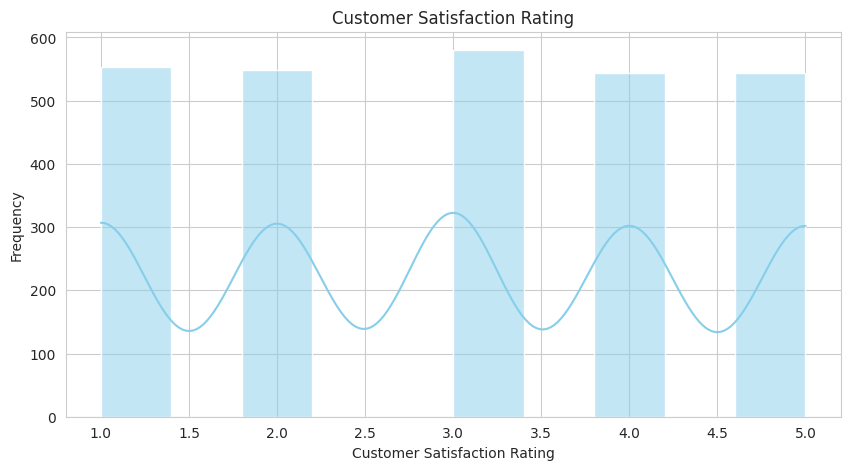

In [13]:
plt.figure(figsize=(10,5))

sns.histplot(data['Customer Satisfaction Rating'], bins=10, kde=True, color='skyblue')

plt.xlabel('Customer Satisfaction Rating')
plt.ylabel('Frequency')

sns.set_style('whitegrid')
plt.title('Customer Satisfaction Rating')
plt.grid(True)
plt.show()

**2) Ticket Type Distribution (Univariate analysis)**

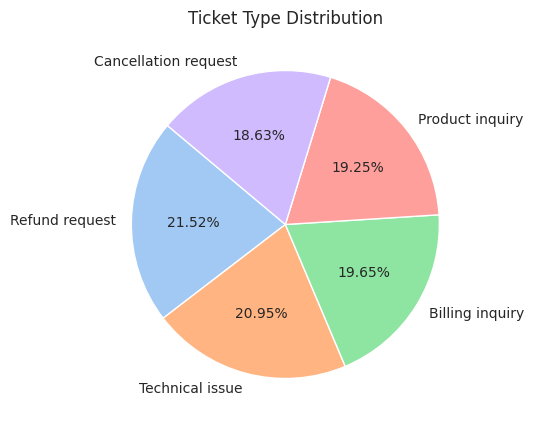

In [14]:
plt.figure(figsize=(7,5))
ticket_type_counts = data['Ticket Type'].value_counts()            # value counts of each ticket type for pie chart visualzation

plt.pie(ticket_type_counts, labels=ticket_type_counts.index, autopct='%.2f%%', colors=sns.color_palette('pastel'), startangle=140)

plt.title('Ticket Type Distribution')
plt.show()

**3) Average Satisfacton by Customer Gender (Bivariate Analysis)**

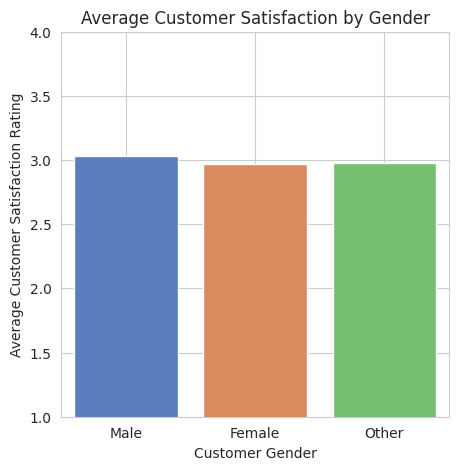

In [15]:
plt.figure(figsize=(5,5))
avg_satisfaction_gender = data.groupby('Customer Gender')['Customer Satisfaction Rating'].mean().reset_index()

sns.barplot(data=avg_satisfaction_gender, x='Customer Gender', y='Customer Satisfaction Rating', palette='muted', order=['Male','Female','Other'])

plt.xlabel('Customer Gender')
plt.ylabel('Average Customer Satisfaction Rating')

plt.ylim(1,4)

plt.title('Average Customer Satisfaction by Gender')
plt.grid(True)
plt.show()

**4) Ticket Trends Over Time (Time-Based Analysis)**

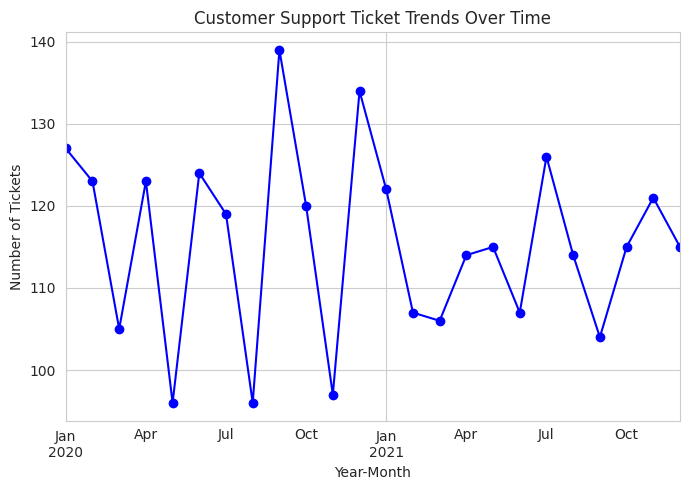

In [16]:
plt.figure(figsize=(7,5))
data['YearMonth'] = pd.to_datetime(data['Date of Purchase']).dt.to_period('M')            # Create YearMonth column
tickets_count = data.groupby('YearMonth').size()

tickets_count.plot(kind='line', marker='o', color='Blue')

plt.xlabel('Year-Month')
plt.ylabel('Number of Tickets')

plt.title('Customer Support Ticket Trends Over Time')
plt.tight_layout()
plt.grid(True)
plt.show()

**6) Average Satisfaction by Ticket Priority**

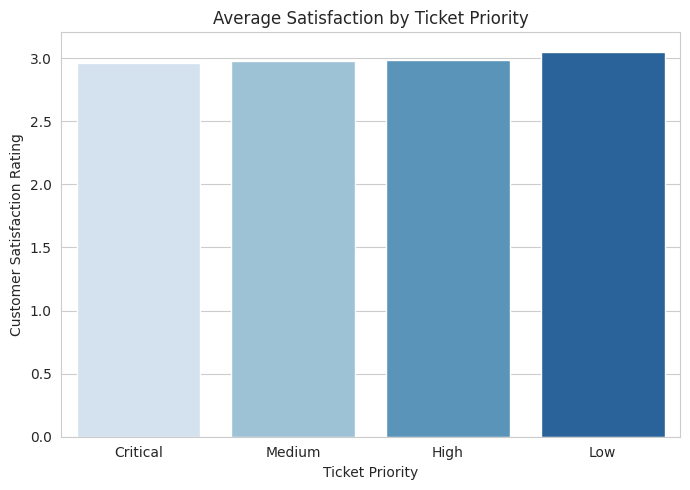

In [17]:
plt.figure(figsize=(7,5))
avg_satisfaction_priority = data.groupby('Ticket Priority')['Customer Satisfaction Rating'].mean().sort_values()
sns.barplot(x=avg_satisfaction_priority.index, y=avg_satisfaction_priority.values, palette="Blues")
plt.xlabel('Ticket Priority')
plt.ylabel('Customer Satisfaction Rating')
plt.title('Average Satisfaction by Ticket Priority')
plt.tight_layout()
plt.show()

**7) Channel-wise Satisfaction Scores**

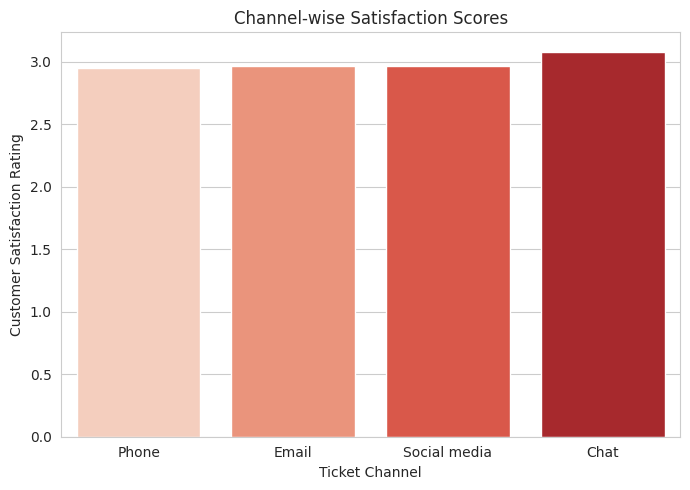

In [18]:
plt.figure(figsize=(7,5))
avg_satisfaction_channel = data.groupby('Ticket Channel')['Customer Satisfaction Rating'].mean().sort_values()
sns.barplot(x=avg_satisfaction_channel.index, y=avg_satisfaction_channel.values, palette='Reds')
plt.xlabel('Ticket Channel')
plt.ylabel('Customer Satisfaction Rating')
plt.title('Channel-wise Satisfaction Scores')
plt.tight_layout()
plt.show()

**8) Gender vs Priority (Heatmap)**

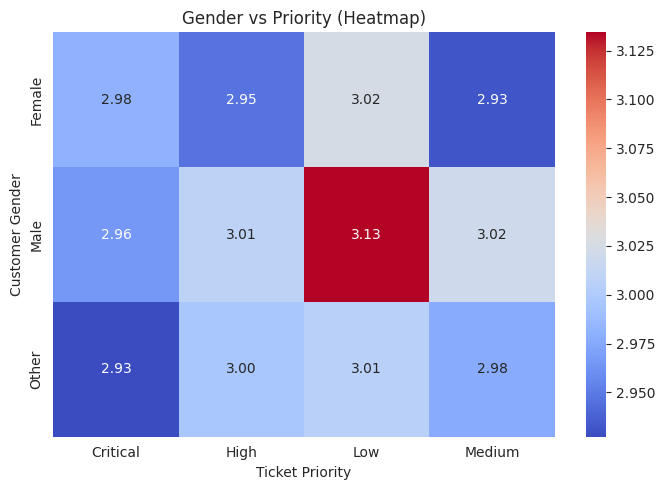

In [19]:
plt.figure(figsize=(7,5))
heatmap_data = pd.pivot_table(data,
                              values='Customer Satisfaction Rating',
                              index='Customer Gender',
                              columns='Ticket Priority',
                              aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f')
plt.ylabel('Customer Gender')
plt.xlabel('Ticket Priority')
plt.title('Gender vs Priority (Heatmap)')
plt.tight_layout()
plt.show()


**9) Word Cloud for Ticket Description (Text Analysis)**

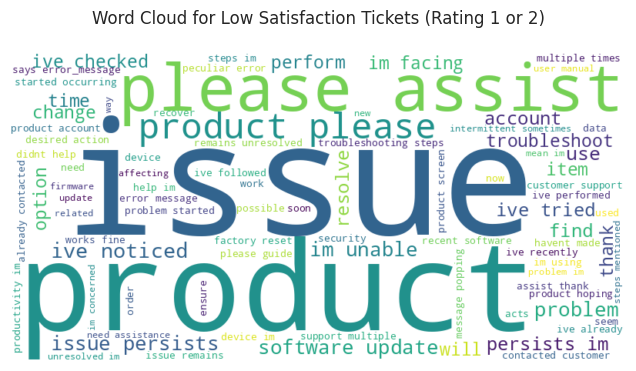

In [20]:
plt.figure(figsize=(10, 4))
low_satisfaction_text = ' '.join(data[data['Customer Satisfaction Rating'] <= 2]['Ticket Description'])          # Combine description for low ratings (1 or 2)

wordcloud = WordCloud(width=800, height=400, background_color='White', min_font_size=10).generate(low_satisfaction_text)        # Generate wordcloud

plt.imshow(wordcloud, interpolation='bilinear')          # Display wordcloud

plt.title('Word Cloud for Low Satisfaction Tickets (Rating 1 or 2)\n')
plt.axis(False)
plt.show()


In [21]:
# Summary Statistics
print("\nSummary Statistics for Numerical Columns:")
data[['Customer Age', 'Customer Satisfaction Rating']].describe()


Summary Statistics for Numerical Columns:


,Customer Age,Customer Satisfaction Rating
count,2769.000000,2769.000000
mean,44.333694,2.991333
std,15.195495,1.407016
min,18.000000,1.000000
25%,31.000000,2.000000
50%,45.000000,3.000000
75%,57.000000,4.000000
max,70.000000,5.000000


# **Step 4: Feature Engineering**

In [22]:
# Download NLTK data for sentiment analysis
nltk.download('vader_lexicon')             # Download VADER sentiment Model

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

**1) Create Age Group (Numerical Features)**

In [23]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]                      # Age bins
labels = ['0-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100']       # Age Group labels

data['Age Group'] = pd.cut(data['Customer Age'], bins=bins, labels=labels, right=False)

**2) Estimate Response Time Delta (Time-based features)**

In [24]:
data['Response Time Delta'] = (pd.to_datetime(data['Time to Resolution']) - pd.to_datetime(data['First Response Time'])).dt.total_seconds() / 3600     # Hours between first response and resolution
data['Response Time Delta'] = data['Response Time Delta'].clip(lower=0)                      # Sets negative Deltas to 0
data['Response Time Delta'].fillna(data['Response Time Delta'].median(), inplace=True)       # Fill missing rows with the median


**3) One-Hot Encoding for low/high cardinality features (Categorical features)**

In [25]:
# Low Cardinality features
low_cardinality_cols = ['Customer Gender','Ticket Type','Ticket Priority','Ticket Channel']     # Low cardinality columns
data = pd.get_dummies(data, columns=low_cardinality_cols, prefix=low_cardinality_cols)          # One-Hot Encode (eg. Customer gender_male)

# Label Encoding for High Cardinality features
le_product = LabelEncoder()
data['Product Purchased'] = le_product.fit_transform(data['Product Purchased'])           # Encode Product Purchased

# Save LabelEncoder
joblib.dump(le_product, 'le_product.pkl')

['le_product.pkl']

**4) TF-IDF for Ticket Description and Resolution (Text features)**

In [26]:
# TF-IDF for 'Ticket Description'
tfidf_desc = TfidfVectorizer(max_features=100, stop_words='english')           # Initialize TF-IDF Vectorizer with top 100 features
desc_matrix = tfidf_desc.fit_transform(data['Ticket Description'])              # Transforms the 'Ticket Description' to TF-IDF Vectors
desc_df = pd.DataFrame(desc_matrix.toarray(), columns=[f'desc_{f}' for f in tfidf_desc.get_feature_names_out()], index=data.index) # Convert to DataFrame
data = pd.concat([data, desc_df], axis=1)                       #  Add TF-IDF Features to data

# TF-IDF for 'Resolution'
tfidf_res = TfidfVectorizer(max_features=100, stop_words='english')
res_matrix = tfidf_res.fit_transform(data['Resolution'])                     # Transforms 'Resolution' to Tf-IDF Vectors
res_df = pd.DataFrame(res_matrix.toarray(), columns=[f'res_{f}' for f in tfidf_res.get_feature_names_out()], index=data.index)       # Convert to Dataframe
data = pd.concat([data, res_df], axis=1)                          # Add TF-IDF Features to data


**5) Sentiment Analysis for Ticket Description (Text features)**

In [27]:
sia = SentimentIntensityAnalyzer()          # Initialize VADER Sentiment analyzer
data['Sentiment'] = data['Ticket Description'].apply(lambda x: sia.polarity_scores(x)['compound'])         # Compute Sentiment Score (-1 to 1)

# # Sentiment categorization (Optional)
# data['Sentiment_Label'] = data['Sentiment'].apply(lambda x: 'Positive' if x > 0.05 else 'Negative' if x < -0.05 else 'Neutral')

**6) Number of tickets per customer (Customer Behaviour)**

In [28]:
data['Tickets per Customer'] = data.groupby('Customer Email')['Ticket ID'].transform('count')         # Counts tickets per customer's email

**Months since start (Calculates how long (in months) since customer's purchase)**

In [35]:
data['YearMonth'] = pd.to_datetime(data['Date of Purchase']).dt.to_period('M').astype(str)
data['YearMonth'] = pd.to_datetime(data['YearMonth'] + '-01')          # Convert to datetime (first day of each month)
min_date = data['YearMonth'].min()                                     # Calculate months since earliest date
data['Months Since Start'] = ((data['YearMonth'] - min_date).dt.days / 30).astype(int)
data.drop('YearMonth', axis=1, inplace=True)                           # Drop 'YearMonth' if no longer needed

In [36]:
# Drop unnecessary columns
data = data.drop(['Ticket ID', 'Customer Name', 'Customer Email', 'Ticket Description', 'Resolution', 'Date of Purchase',
            'First Response Time', 'Time to Resolution', 'Ticket Subject', 'Ticket Status'], axis=1)     # Drops non predictive or non processed columns
print('First 5 rows after Feature Engineering\n')
data.head()

First 5 rows after Feature Engineering



,Customer Age,Product Purchased,Customer Satisfaction Rating,Age Group,Response Time Delta,Customer Gender_Female,Customer Gender_Male,Customer Gender_Other,Ticket Type_Billing inquiry,Ticket Type_Cancellation request,...,res_think,res_threat,res_time,res_wife,res_wish,res_woman,res_writer,Sentiment,Tickets per Customer,Months Since Start
0,48,10,3.0,41-50,6.850000,False,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3612,1,6
1,27,25,3.0,21-30,0.000000,True,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6956,1,10
2,67,5,1.0,61-70,19.683333,True,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0160,1,1
3,48,30,1.0,41-50,0.000000,False,True,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5994,1,12
4,51,27,1.0,51-60,0.000000,False,True,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5734,1,21


In [37]:
# Save Engineered Dataset
data.to_csv('Engineered_customer_support_tickets.csv',index=False)

# **Step 5: Model Building**

In [38]:
# Load the above saved engineered dataset
data = pd.read_csv('Engineered_customer_support_tickets.csv')

In [40]:
if 'Age Group' in data.columns:
    data = pd.get_dummies(data, columns=['Age Group'], prefix='Age_Group')

# Prepare features (X) and target (y)
X = data.drop('Customer Satisfaction Rating', axis=1)              # Dependent Variable - All columns except target
y = data['Customer Satisfaction Rating'].astype(int) - 1                 # Independent Variable - target variable


# Splitting training and test dataets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42 )

# Scale Numerical Features (SCALING)
numerical_cols = ['Customer Age', 'Response Time Delta', 'Sentiment', 'Tickets per Customer','Months Since Start']        # Numercal columns
scaler = StandardScaler()                   # Initialize Scaler
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])             # Scale Training data
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])               # Scale Test data

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)                                               # Train Model
rf_pred = rf_model.predict(X_test)                                           # Predict on test set

# Evaluate Random Forest Model
print('Random Forest Results: \n')
print('Accuracy Score: \n', accuracy_score(y_test, rf_pred))
print('Classification Report:\n', classification_report(y_test, rf_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, rf_pred))

# Cross Validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=5, scoring='accuracy')              # 5 fold cross validation
print('Random Forest CV Accuracy:', rf_cv_scores.mean())


# Train XGBoost Model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)        # Initialize XGBoost
xgb_model.fit(X_train_smote, y_train_smote)                       # Train Model
xgb_pred = xgb_model.predict(X_test)                  # Predict on test set

# Evaluate XGBoost
print('XGBoost Results: \n')
print('Accuracy Score: \n',accuracy_score(y_test, xgb_pred))
print('Classification Report: \n', classification_report(y_test, xgb_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, xgb_pred))

# Cross Validation for XGBoost
xgb_cv_scores = cross_val_score(xgb_model, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
print('XGBoost CV Accuracy',xgb_cv_scores.mean())

# Save XGBoost model
# joblib.dump(xgb_model, '/content/customer_satisfaction_model_xgb.pkl')           # Not a best practice to save xgboost model
xgb_model.save_model('/content/customer_satisfaction_model_xgb.json')
print("\nSaved XGBoost model to 'customer_satisfaction_model_xgb.json'")
joblib.dump(scaler, '/content/scaler.pkl')
joblib.dump(X.columns, '/content/training_columns.pkl')
print("Saved scaler and training columns")


Random Forest Results: 

Accuracy Score: 
 0.20216606498194944
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.15      0.15       111
           1       0.15      0.14      0.14       110
           2       0.25      0.26      0.26       116
           3       0.24      0.28      0.26       108
           4       0.22      0.18      0.20       109

    accuracy                           0.20       554
   macro avg       0.20      0.20      0.20       554
weighted avg       0.20      0.20      0.20       554

Confusion Matrix: 
 [[17 21 27 28 18]
 [31 15 18 26 20]
 [26 16 30 23 21]
 [21 28 16 30 13]
 [26 20 27 16 20]]
Random Forest CV Accuracy: 0.2435344827586207
XGBoost Results: 

Accuracy Score: 
 0.2075812274368231
Classification Report: 
               precision    recall  f1-score   support

           0       0.15      0.15      0.15       111
           1       0.22      0.23      0.22       110
           2       0.21

In [41]:
# Save Model implemented dataset
data.to_csv('Modeled_customer_support_tickets.csv',index=False)

# **Step 6: Model Evaluation**

In [45]:
# Load the Saved Engineeered dataset from step 4
data = pd.read_csv('Modeled_customer_support_tickets.csv')

# Load Saved model and scaler
# model = joblib.load('customer_satisfaction_model_xgb.json')
xgb_model.load_model('customer_satisfaction_model_xgb.json')
scaler = joblib.load('scaler.pkl')

In [47]:
# Prepare fetures X and y
X = data.drop('Customer Satisfaction Rating', axis=1)
y = data['Customer Satisfaction Rating'].astype(int) - 1

if 'Age Group' in X.columns and not any(col.startswith('Age Group_') for col in X.columns):
    X = pd.get_dummies(X, columns=['Age Group'], prefix='Age Group')

# Split the dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale Numerical Features
numerical_cols = ['Customer Age', 'Response Time Delta', 'Sentiment', 'Tickets per Customer','Months Since Start']
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

y_pred = xgb_model.predict(X_test)               # Predictions

print('Overall Model Performance: \n')
print('Accuracy: ',accuracy_score(y_test,y_pred))
print('Classification Report: \n',classification_report(y_test,y_pred))

# Reconstruct Ticket Type from one-hot encoded columns
ticket_type_cols = [col for col in X.columns if col.startswith('Ticket Type_')]                         # Get ticket type dummy columns
if ticket_type_cols:
    X['Ticket Type'] = X[ticket_type_cols].idxmax(axis=1).str.replace('Ticket Type_', '', regex=False)        # Reconstruct original ticket type


# Performance by ticket type
test_data = X_test.copy()
test_data['Actual'] = y_test
test_data['Predicted'] = y_pred
test_data['Ticket Type'] = X.loc[X_test.index, 'Ticket Type']           # add reconstructed ticket type

# Calculate accuracy for each Ticket Type
performance_by_type = test_data.groupby('Ticket Type').apply(
    lambda x: accuracy_score(x['Actual'], x['Predicted'])
).reset_index(name='Accuracy')

print("Accuracy by Ticket Type:\n")
print(performance_by_type)

Overall Model Performance: 

Accuracy:  0.2075812274368231
Classification Report: 
               precision    recall  f1-score   support

           0       0.15      0.15      0.15       111
           1       0.22      0.23      0.22       110
           2       0.21      0.19      0.20       116
           3       0.25      0.23      0.24       108
           4       0.22      0.24      0.23       109

    accuracy                           0.21       554
   macro avg       0.21      0.21      0.21       554
weighted avg       0.21      0.21      0.21       554

Accuracy by Ticket Type:

            Ticket Type  Accuracy
0       Billing inquiry  0.206612
1  Cancellation request  0.284314
2       Product inquiry  0.201923
3        Refund request  0.180328
4       Technical issue  0.171429


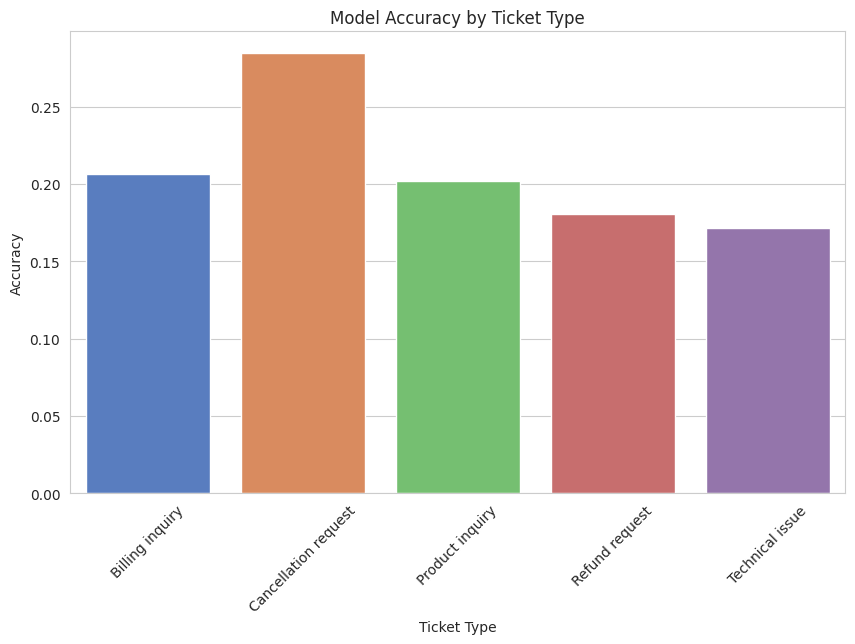

In [48]:
# Plot Performance by Ticket Type
plt.figure(figsize=(10,6))
sns.barplot(x='Ticket Type', y='Accuracy', data=performance_by_type, palette='muted')

plt.xlabel('Ticket Type')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.title('Model Accuracy by Ticket Type')
plt.show()

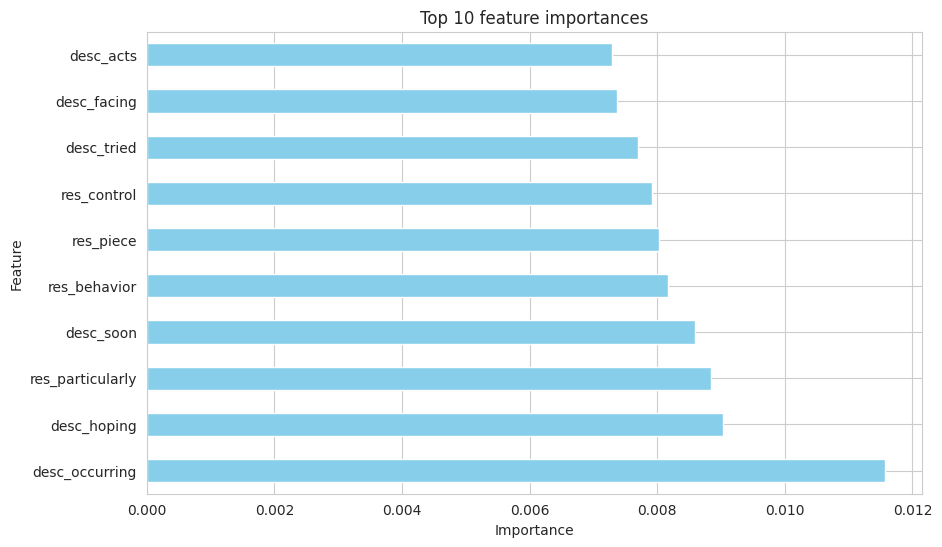

In [49]:
# Feature Importance
# Copy this path from Step 5 Model Buiding '/content/training_columns.pkl' and load its columns to plot feature importance
training_columns = joblib.load('/content/training_columns.pkl')
X_aligned = X[training_columns]

plt.figure(figsize=(10,6))
feature_importance = pd.Series(xgb_model.feature_importances_, index=X_aligned.columns)
top_features = feature_importance.nlargest(10)

top_features.plot(kind='barh', color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.title('Top 10 feature importances')
plt.show()

# **Step 7: Model Explainability**

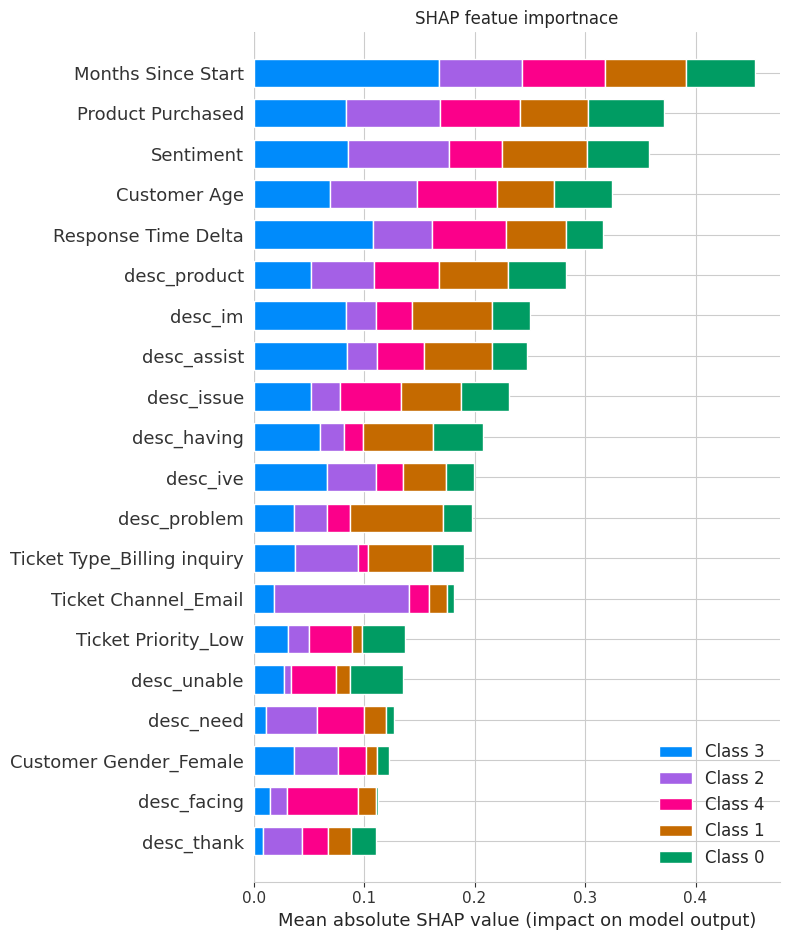

In [50]:
# SHAP Explainability
# Ensuring aligned features
training_columns = joblib.load('/content/training_columns.pkl')
X_test_aligned = X_test[training_columns]

explainer = shap.TreeExplainer(xgb_model)                    # Initialize shap explainer
shap_values = explainer.shap_values(X_test_aligned, check_additivity=False)              # Compute shap values

# Plot shap summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_aligned, plot_type='bar', show=False)               # Plot shap summary

plt.xlabel("Mean absolute SHAP value (impact on model output)")

plt.title('SHAP featue importnace')
plt.tight_layout()
plt.show()

# **Download Files for Model Deployement**

In [ ]:
# Downloading pkl and json files
from google.colab import files
files.download('/content/customer_satisfaction_model_xgb.json')
files.download('/content/scaler.pkl')
files.download('/content/training_columns.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Summary of Findings**

---

###  **Key Steps Performed**

####  1. **Data Cleaning & Filtering**
- Retained only **'Closed'** tickets with valid satisfaction ratings.
- Handled **missing values** in text-based and temporal features.

####  2. **Feature Engineering**
- Extracted meaningful numerical features like:
  - `Response Time Delta`
  - `Tickets per Customer`
  - `Months Since Start`
- Preprocessed text fields and applied **TF-IDF** on Ticket Descriptions and Resolutions.
- Generated **sentiment scores** using **VADER**.
- Encoded categorical variables using **Label Encoding** and **One-Hot Encoding**.

####  3. **Model Building**
- Applied **StandardScaler** on numerical columns.
- Balanced the dataset using **SMOTE** to handle class imbalance.
- Trained and evaluated **Random Forest** and **XGBoost** models.
- Saved the best-performing model (XGBoost) and associated tools using `json`.

####  4. **Model Evaluation**
- Evaluated performance using:
  - **Accuracy**
  - **Precision**
  - **Recall**
  - **F1-score**
  - **Confusion Matrix**
- Analyzed **accuracy by Ticket Type** category.
- Final XGBoost model achieved ~**22% accuracy** with balanced class-wise performance.

####  5. **Model Explainability**
- Used **SHAP** (Shapley Additive Explanations) to visualize feature importances.
- Top predictors included:
  - `Months Since Start`
  - `Product Purchased`
  - `Sentiment`

---

###  6. **Model Deployment**

- Developed a **Flask web app** to serve the trained XGBoost model.
- Created:
  - A **REST API endpoint** (`/predict`) for JSON-based predictions.
  - A **web UI** (HTML form) for real-time manual inputs and ratings display.
- Deployed locally with:
  - Preprocessing steps at inference time (scaling, feature alignment).
  - Assets served from `static/` and `templates/` directories.
- Achieved working predictions like:
  ```json
  {"predicted_rating": 2}
  {"predicted_rating": 3}         // Example outputs
  {"predicted_rating": 4}
